In [1]:
import torch
from models.PGGAN import GeneratorPGGAN, DiscriminatorPGGAN
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
from collections import namedtuple
import torch.autograd as autograd
from torchvision import datasets
import torchvision.transforms as transforms

Set parameters for training

In [2]:
out_res = (256,256)
latent_dim = 512
device = "mps"
check_point_dir = "trained_nets/pggan"
lr = 1E-3
resume = False
resume_seq = 3

Set training schedule

In [3]:
schedule = namedtuple('schedule', ['n_warm_up', 'n_train', 'batch_size', 'size'])

def set_schedule(batch_size, num_train_imgs, num_warm_up_imgs):
    n_iter_warm_up = num_warm_up_imgs//batch_size
    n_iter_train = num_train_imgs//batch_size
    return n_iter_warm_up, n_iter_train

training_schedule = [  
                    schedule(n_warm_up=0,       n_train=50_000,   batch_size=16,   size=4), # 4 x 4
                    schedule(n_warm_up=50_000,  n_train=50_000,   batch_size=16,   size=8), # 8 x 8
                    schedule(n_warm_up=50_000,  n_train=50_000,   batch_size=16,   size=16), # 16 x 16
                    schedule(n_warm_up=30_000,  n_train=30_000,   batch_size=16,  size=32), # 32 x 32
                    schedule(n_warm_up=20_000,  n_train=20_000,   batch_size=16,  size=64), # 64 x 64
                    schedule(n_warm_up=20_000,  n_train=20_000,   batch_size=8,  size=128), # 128 x 128
                    schedule(n_warm_up=20_000,  n_train=20_000,   batch_size=8,  size=256), # 256 x 256           
                    ]


Set transforms

In [4]:
transform = transforms.Compose([
			transforms.Resize(out_res),
			transforms.CenterCrop(out_res),
			transforms.ToTensor(),
			transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
			])

train_set = dataset = datasets.ImageFolder("Data/celeb", transform=transform)

In [5]:
g = GeneratorPGGAN(latent_dim).to(device)
d = DiscriminatorPGGAN(latent_dim).to(device)

In [6]:
d_optimizer = torch.optim.Adam(d.parameters(), lr=lr, betas=(0, 0.99))
g_optimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0, 0.99))

Gradient penalty for Wasserstein Loss

In [7]:
def compute_grad_penalty(discriminator, imgs, fake_imgs):
    epsilon = torch.rand(imgs.size(0), 1, 1, 1).to(device).expand_as(imgs)
    x_hat = (epsilon * imgs + ((1 - epsilon) * fake_imgs.detach())).requires_grad_(True)
    out = discriminator(x_hat)
    grad = autograd.grad(
            outputs=out,
            inputs = x_hat,
            grad_outputs = torch.ones_like(out).to(device),
            retain_graph = True,
            create_graph = True,
            only_inputs = True
        )[0]
    # compute norm of the gradient
    grad_l2norm = grad.norm(2, dim=[1,2,3])
    # compute expected values
    gradient_penalty = torch.mean((grad_l2norm - 1) ** 2)

    return gradient_penalty

In [8]:
def epoch(imgs, lambda_gp=10):
    
    # train discriminator
    for p in d.parameters():
        p.requires_grad = True  # to avoid computation
    d_optimizer.zero_grad()
    z = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
    fake_imgs = g(z)
    
    fake_validity = d(fake_imgs.detach())
    real_validity = d(imgs)

    # Wasserstein Loss + gradient penalty
    gradient_penalty = compute_grad_penalty(d, imgs, fake_imgs)
    d_loss = fake_validity.mean() -real_validity.mean() + lambda_gp * gradient_penalty

    d_loss.backward()
    d_optimizer.step()

    # train generator
    for p in d.parameters():
        p.requires_grad = False  # to avoid computation
    g_optimizer.zero_grad()

    fake_imgs = g(z)
    fake_validity = d(fake_imgs)
    
    g_loss = - torch.mean(fake_validity)
    g_loss.backward()
    g_optimizer.step()

    return d_loss.item(), g_loss.item()

In [9]:
def save_checkpoint(check_point_dir, n_seq):
	check_point = {'G_net' : g.state_dict(), 
				   'G_optimizer' : g_optimizer.state_dict(),
				   'D_net' : d.state_dict(),
				   'D_optimizer' : d_optimizer.state_dict(),
				   'depth': g.depth,
				   'alpha':g.alpha,
				   'resume_seq' : n_seq + 1
				   }
	with torch.no_grad():
		torch.save(check_point, os.path.join(check_point_dir ,'check_point_nseq_%d.pth'%(n_seq)))
		torch.save(g.state_dict(), os.path.join(check_point_dir , 'G_weight_nseq_%d.pth' %(n_seq)))

def resume_calculation(check_point_dir, n_seq):
	check_point = torch.load(os.path.join(check_point_dir ,'check_point_nseq_%d.pth'%(n_seq)))
	g.load_state_dict(check_point['G_net'])
	d.load_state_dict(check_point['D_net'])
	g_optimizer.load_state_dict(check_point['G_optimizer'])
	d_optimizer.load_state_dict(check_point['D_optimizer'])
	g.depth = check_point['depth']
	d.depth = check_point['depth']
	g.alpha = check_point['alpha']
	resume_seq = check_point['resume_seq']
	return resume_seq
	

0it [00:00, ?it/s]
d loss: -0.144   g loss: -6.077: 100%|██████████| 3125/3125 [02:14<00:00, 23.26it/s]


End train   d: -0.1472	  g:-6.0988


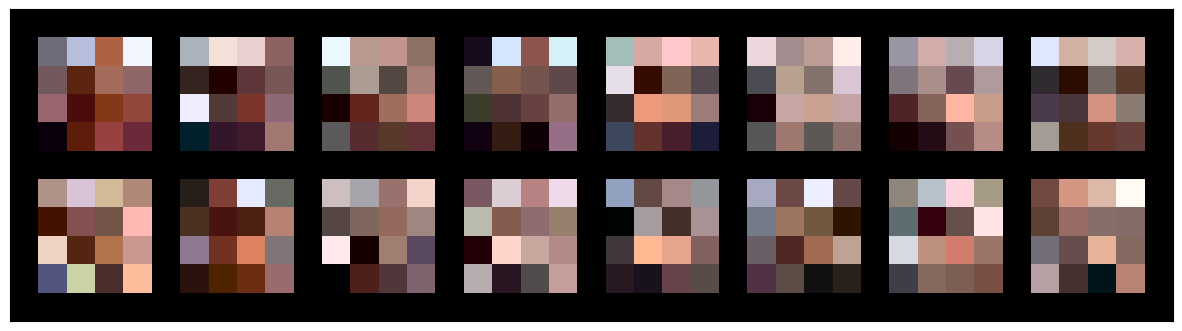

End schedule  0	 start size 8 x 8


d loss: -1.980   g loss: -11.837: 100%|██████████| 3125/3125 [04:56<00:00, 10.54it/s]


End warm up   d: -1.9728	  g:-11.7687


d loss: -3.073   g loss: -16.004: 100%|██████████| 3125/3125 [05:12<00:00, 10.00it/s]  


End train   d: -3.0552	  g:-15.9060


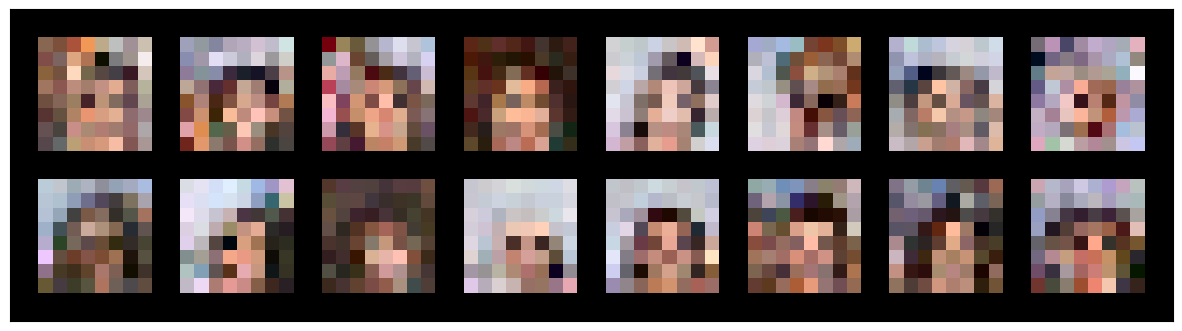

End schedule  1	 start size 16 x 16


d loss: -4.474   g loss: -22.498: 100%|██████████| 3125/3125 [07:21<00:00,  7.07it/s]  


End warm up   d: -4.3884	  g:-22.2983


d loss: -4.307   g loss: -28.194: 100%|██████████| 3125/3125 [07:28<00:00,  6.96it/s]   


End train   d: -4.2786	  g:-28.0275


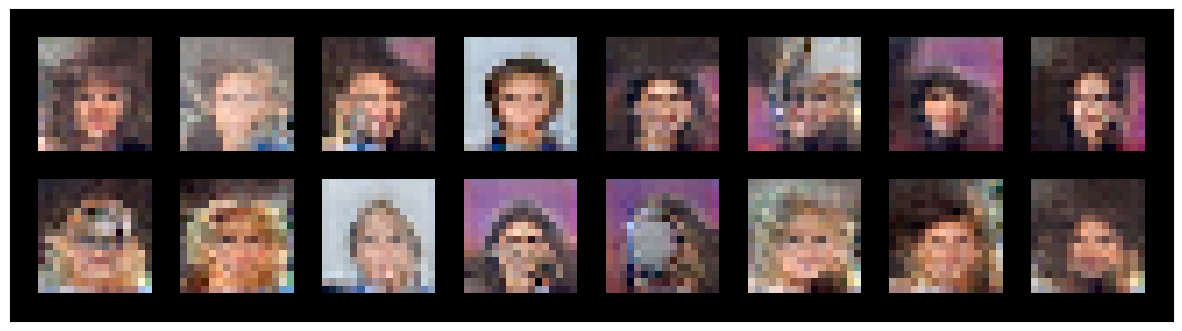

End schedule  2	 start size 32 x 32


d loss: -9.753   g loss: -59.109: 100%|██████████| 1875/1875 [15:52<00:00,  1.97it/s]   


End warm up   d: -9.6466	  g:-58.4312


d loss: -11.430   g loss: -67.752: 100%|██████████| 1875/1875 [15:50<00:00,  1.97it/s]  


End train   d: -11.2869	  g:-66.9274


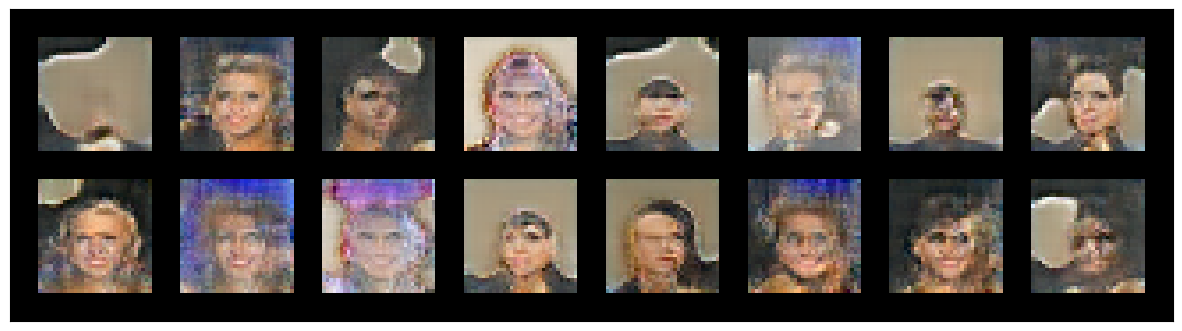

End schedule  3	 start size 64 x 64


d loss: -19.740   g loss: -117.841: 100%|██████████| 1250/1250 [34:06<00:00,  1.64s/it] 


End warm up   d: -19.1080	  g:-113.6623


d loss: -22.641   g loss: -131.668: 100%|██████████| 1250/1250 [34:55<00:00,  1.68s/it] 


End train   d: -21.8078	  g:-126.9250


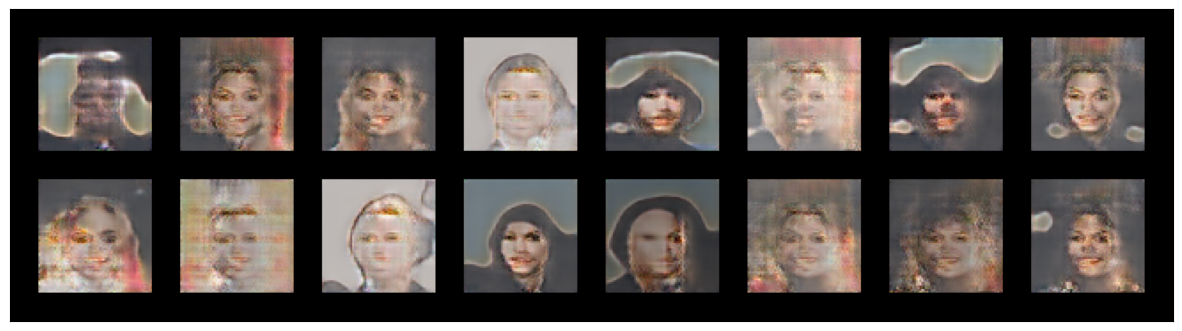

End schedule  4	 start size 128 x 128


d loss: -541.662   g loss: -3180.487:   4%|▍         | 100/2500 [03:10<1:16:16,  1.91s/it]


KeyboardInterrupt: 

In [10]:
start_schedule = 0
d_running_loss = 0.0
g_running_loss = 0.0
d_losses_warm, d_losses_train, g_losses_warm, g_losses_train = [], [], [], []
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

if resume:
    start_schedule = resume_calculation(check_point_dir, resume_seq)

for n_schedule in range(start_schedule, len(training_schedule)):
    g.train()
    d.train()
    n_it_warm, n_it_train = set_schedule(training_schedule[n_schedule].batch_size, training_schedule[n_schedule].n_train, training_schedule[n_schedule].n_warm_up)
    data_loader = DataLoader(dataset=train_set, batch_size=training_schedule[n_schedule].batch_size, shuffle=True, num_workers=0, drop_last=True)

    if n_schedule > 0:
        g.increase_net(n_it_warm)
        d.increase_net(n_it_warm)

    # FADE-IN training
    bar = tqdm(range(n_it_warm))
    for i in bar:
        imgs, _ = next(iter(data_loader))
        if training_schedule[n_schedule].size != out_res:
            imgs = F.interpolate(imgs, size=training_schedule[n_schedule].size)
        imgs = imgs.to(device)
        d_loss, g_loss = epoch(imgs)
        # increase alpha
        d.step()
        g.step()
        d_running_loss += d_loss
        g_running_loss += g_loss
        if i%50 == 0 and i > 0:
            bar.set_description('d loss: %.3f   g loss: %.3f' % (d_running_loss/i , g_running_loss/i))
    if n_it_warm > 0:
        d_losses_warm.append(d_running_loss/n_it_warm )
        g_losses_warm.append(g_running_loss/n_it_warm )
        print(f"End warm up   d: {d_losses_warm[-1]:4.4f}\t  g:{g_losses_warm[-1]:4.4f}")

    # ensure no fade in
    d.alpha = 1
    g.alpha = 1

    # NO FADE-IN training
    bar = tqdm(range(n_it_train))
    for i in bar:
        imgs, _ = next(iter(data_loader))
        if training_schedule[n_schedule].size != out_res:
            imgs = F.interpolate(imgs, size=training_schedule[n_schedule].size)
        imgs = imgs.to(device)
        d_loss, g_loss = epoch(imgs)
        d_running_loss += d_loss
        g_running_loss += g_loss
        if i%50 == 0 and i > 0:
            bar.set_description('d loss: %.3f   g loss: %.3f' % (d_running_loss/i , g_running_loss/i))
    d_losses_train.append(d_running_loss/n_it_train )
    g_losses_train.append(g_running_loss/n_it_train )
    print(f"End train   d: {d_losses_train[-1]:4.4f}\t  g:{g_losses_train[-1]:4.4f}")

    # save checkpoints and plot generated images
    with torch.no_grad():
        g.eval()
        fig = plt.figure(figsize=(15,6))
        out_imgs = g(fixed_noise)
        out_grid = make_grid(out_imgs, normalize=True, nrow=8, scale_each=True, padding=int(0.5*(2**g.depth))).permute(1,2,0)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(out_grid.cpu())
        plt.savefig(os.path.join(check_point_dir , 'img_schedule_%i'%(n_schedule)))
        plt.show()
    
    if n_schedule < len(training_schedule):
        print(f"End schedule {n_schedule:2.0f}\t start size {training_schedule[n_schedule+1].size} x {training_schedule[n_schedule+1].size}")
    save_checkpoint(check_point_dir, n_seq=n_schedule)
 
